In [1]:
# Importing the PySpark Libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import random
import plotly.express as px
import plotly.io as pio


In [2]:
# Running the Spark Session
spark = SparkSession.builder.appName("demographic").getOrCreate()


In [3]:
# Loading the csv data into the Spark DF
path = "resources/data/AgeDataset-V1.csv"

demographics_schema = StructType([
    StructField("Id", StringType(), True),
    StructField("Name", StringType(), True),
    StructField("Short description",StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("Country", StringType(), True),
    StructField("Occupation", StringType(), True),
    StructField("Birth year", IntegerType(), True),
    StructField("Death year", IntegerType(), True),
    StructField("Manner of death", StringType(),True),
    StructField("Age of death", IntegerType(), True),
])

df = spark.read.option("header",'True').option('delimiter', ',').schema(demographics_schema).csv(path)
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Short description: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Birth year: integer (nullable = true)
 |-- Death year: integer (nullable = true)
 |-- Manner of death: string (nullable = true)
 |-- Age of death: integer (nullable = true)



In [4]:
# Summary Statistics - 
print(df.limit(10).toPandas()) # Top 10 rows

# no. of rows
print(f"# of Rows : {df.count()}")

# no. of columns
print(f"# of Columns : {len(df.columns)}")


     Id                       Name  \
0   Q23          George Washington   
1   Q42              Douglas Adams   
2   Q91            Abraham Lincoln   
3  Q254    Wolfgang Amadeus Mozart   
4  Q255       Ludwig van Beethoven   
5  Q260  Jean-François Champollion   
6  Q272                Paul Morand   
7  Q296               Claude Monet   
8  Q297            Diego Velázquez   
9  Q301                   El Greco   

                                 Short description Gender  \
0   1st president of the United States (1732–1799)   Male   
1                      English writer and humorist   Male   
2  16th president of the United States (1809-1865)   Male   
3        Austrian composer of the Classical period   Male   
4           German classical and romantic composer   Male   
5                         French classical scholar   Male   
6                                    French writer   Male   
7         French impressionist painter (1840-1926)   Male   
8                      Spanish p

In [5]:
df.describe().show()

+-------+--------+--------------------+------------------+--------------------+---------------+--------------------+------------------+------------------+------------------+-----------------+
|summary|      Id|                Name| Short description|              Gender|        Country|          Occupation|        Birth year|        Death year|   Manner of death|     Age of death|
+-------+--------+--------------------+------------------+--------------------+---------------+--------------------+------------------+------------------+------------------+-----------------+
|  count| 1223009|             1223009|           1155109|             1089396|         887576|             1016052|           1222781|           1222971|             53821|          1222804|
|   mean|    null|                66.0|-186.9090909090909|                null|           null|              1859.0|1844.9705139350383|1914.2348052406803|1918.0096153846155|69.30916156636714|
| stddev|    null|                null| 

In [6]:
# finding missing values in the data
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+----+-----------------+------+-------+----------+----------+----------+---------------+------------+
| Id|Name|Short description|Gender|Country|Occupation|Birth year|Death year|Manner of death|Age of death|
+---+----+-----------------+------+-------+----------+----------+----------+---------------+------------+
|  0|   0|            67900|133613| 335433|    206957|       228|        38|        1169188|         205|
+---+----+-----------------+------+-------+----------+----------+----------+---------------+------------+



In [20]:
# Removing columns with empty or null values
updated_df = df.na.drop(subset=['Gender','Country','Occupation', 'Age of death', 'Death year'])

print(f"# of Rows : {updated_df.count()}")
#updated_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# of Rows : 735684


In [21]:
occ_top_10 = updated_df.groupBy('Occupation').count().orderBy(desc('count')).show()

+------------------+------+
|        Occupation| count|
+------------------+------+
|            Artist|207578|
|        Politician|153139|
|           Athlete| 92806|
|        Researcher| 64194|
|Military personnel| 36312|
|  Religious figure| 18640|
|         Architect| 12612|
|    Businessperson| 12233|
|        Journalist| 10946|
|           Teacher| 10901|
|          Engineer|  8355|
|         Physician|  7591|
|             Judge|  5732|
|            Lawyer|  4467|
|            Jurist|  2849|
|      Entrepreneur|  2504|
|        Aristocrat|  2043|
|        Translator|  1748|
|         Publisher|  1712|
|       Philosopher|  1710|
+------------------+------+
only showing top 20 rows



In [22]:
gender_top = updated_df.groupBy('Gender').count().orderBy(desc('count')).show()

+--------------------+------+
|              Gender| count|
+--------------------+------+
|                Male|662020|
|              Female| 73537|
|  Transgender Female|    57|
|    Transgender Male|    30|
|        Eunuch; Male|    13|
|            Intersex|     7|
|        Female; Male|     5|
|Transgender Male;...|     3|
|          Non-Binary|     2|
|Transgender Perso...|     1|
|      Intersex; Male|     1|
|Transgender Femal...|     1|
|Transgender Femal...|     1|
|Intersex; Transge...|     1|
|Transgender Male;...|     1|
|              Eunuch|     1|
|Transgender Femal...|     1|
|      Female; Female|     1|
|    Intersex; Female|     1|
+--------------------+------+



In [28]:
updated_df.select(countDistinct('Manner of death')).show()

+-------------------------------+
|count(DISTINCT Manner of death)|
+-------------------------------+
|                            177|
+-------------------------------+



In [9]:
# Data Cleaning

# Fetching the top 10 occupations
#occ_top_10 = updated_df.groupBy('Occupation').count().orderBy(desc('count')).limit(10).show()


occ_list = ['Artist', 'Politician','Athelete','Researcher', 'Military personnel','Religious figure','Architect', 'Businessperson','Journalist','Teacher']
# Replacing the Gender into 3 categories (Male/Female/Other)
updated_df = updated_df.withColumn("Gender", when(col("Gender") == "Male", "Male").when(col("Gender") == "Female", "Female").otherwise("Other/Unknown"))
#gen_top_3 = updated_df.groupBy('Gender').count().orderBy(desc('count')).limit(3).show()

# Considering the top 10 occupations
updated_df = updated_df.withColumn("Occupation", when(~col("Occupation").isin(occ_list), "Other").otherwise(df.Occupation))
updated_df.show(10)


+----+--------------------+--------------------+------+--------------------+----------+----------+----------+---------------+------------+
|  Id|                Name|   Short description|Gender|             Country|Occupation|Birth year|Death year|Manner of death|Age of death|
+----+--------------------+--------------------+------+--------------------+----------+----------+----------+---------------+------------+
| Q23|   George Washington|1st president of ...|  Male|United States of ...|Politician|      1732|      1799| natural causes|          67|
| Q42|       Douglas Adams|English writer an...|  Male|      United Kingdom|    Artist|      1952|      2001| natural causes|          49|
| Q91|     Abraham Lincoln|16th president of...|  Male|United States of ...|Politician|      1809|      1865|       homicide|          56|
|Q254|Wolfgang Amadeus ...|Austrian composer...|  Male|Archduchy of Aust...|    Artist|      1756|      1791|           null|          35|
|Q255|Ludwig van Beethoven|

[Text(0.5, 0, 'Counts per Gender'),
 Text(0, 0.5, 'Occupation'),
 [Text(0, 0, 'Military personnel'),
  Text(0, 1, 'Businessperson'),
  Text(0, 2, 'Teacher'),
  Text(0, 3, 'Other'),
  Text(0, 4, 'Architect'),
  Text(0, 5, 'Artist'),
  Text(0, 6, 'Religious figure'),
  Text(0, 7, 'Researcher'),
  Text(0, 8, 'Journalist'),
  Text(0, 9, 'Politician')]]

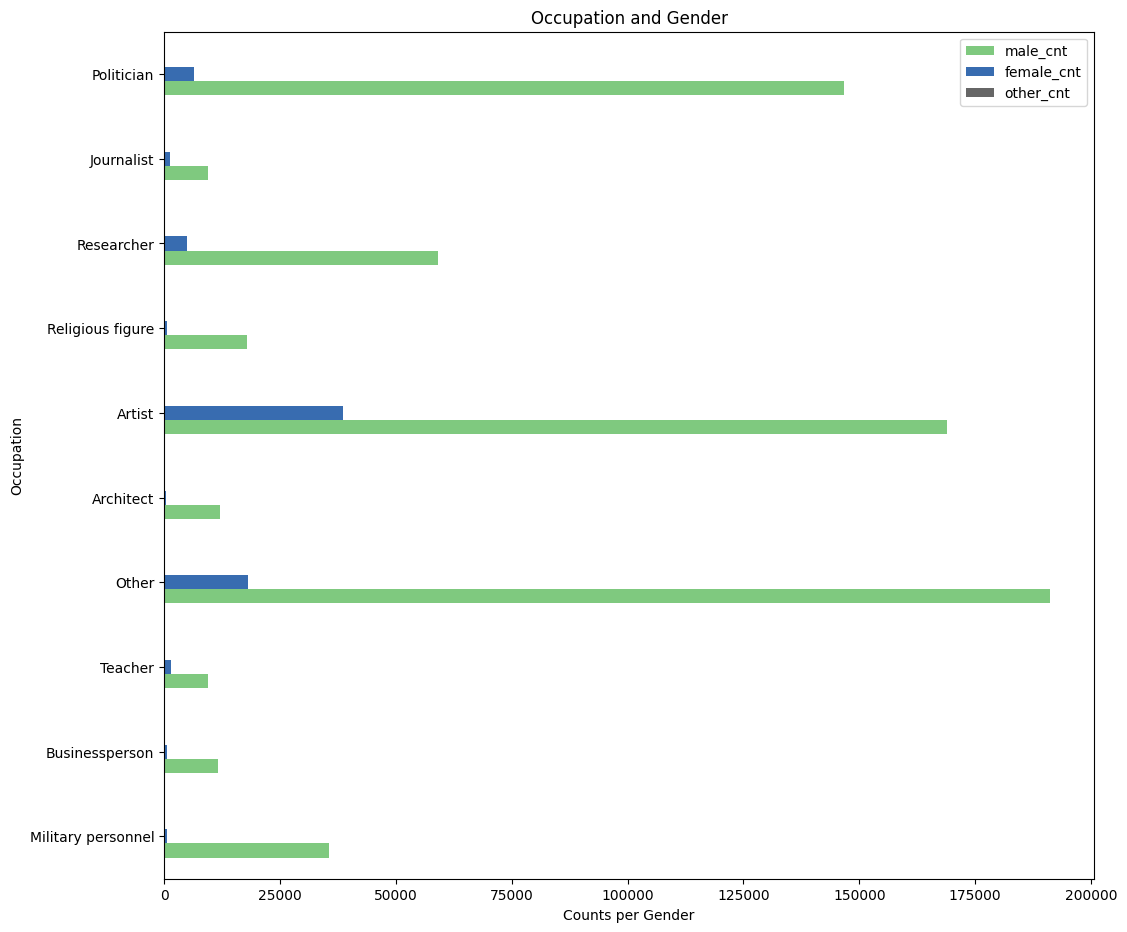

In [10]:
updated_df.createOrReplaceTempView("demographics")

sql_query = """SELECT Occupation, 
                Count(case when Gender='Male' then 1 end) as male_cnt, 
                count(case when Gender='Female' then 1 end) as female_cnt, 
                count(case when Gender='Other/Unknown' then 1 end) as other_cnt
                FROM demographics GROUP BY Occupation
            """
#sql_df = spark.sql(sql_query).show()
ylabels = [i.Occupation for i in updated_df.select('Occupation').distinct().collect()]
spark.sql(sql_query).toPandas().plot(kind='barh', figsize=(12,11), title='Occupation and Gender',cmap = 'Accent').set(xlabel="Counts per Gender", ylabel="Occupation", yticklabels=ylabels)


[Text(0.5, 0, 'Manner of death'),
 Text(0, 0.5, 'Counts'),
 [Text(0, 0, 'natural causes'),
  Text(1, 0, 'suicide'),
  Text(2, 0, 'accident'),
  Text(3, 0, 'homicide'),
  Text(4, 0, 'capital punishment'),
  Text(5, 0, 'unnatural death'),
  Text(6, 0, 'death in battle'),
  Text(7, 0, 'capital punishment; unnatural death'),
  Text(8, 0, 'capital punishment; homicide'),
  Text(9, 0, 'accident; natural causes'),
  Text(10, 0, 'capital punishment; suicide'),
  Text(11, 0, 'suicide; accident'),
  Text(12, 0, 'suicide; homicide'),
  Text(13, 0, 'homicide; homicide'),
  Text(14, 0, 'shipwrecking'),
  Text(15, 0, 'war'),
  Text(16, 0, 'Eastern Front of World War II'),
  Text(17, 0, 'euthanasia'),
  Text(18, 0, 'extrajudicial killing'),
  Text(19, 0, 'suicide; natural causes')]]

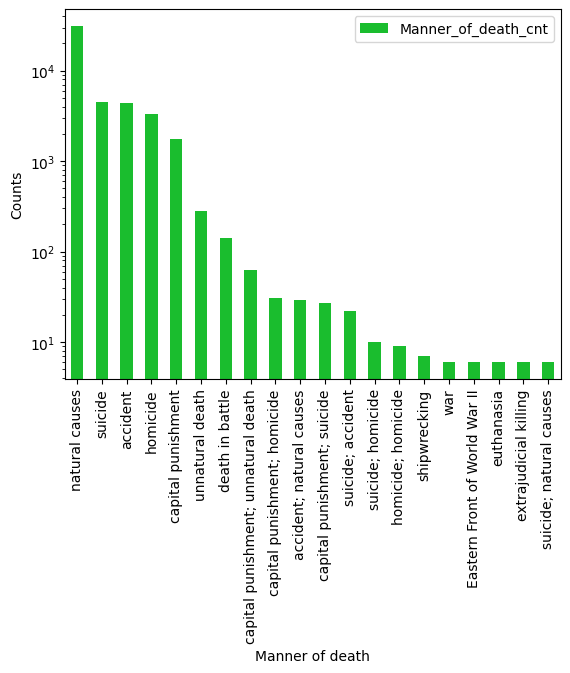

In [11]:
## Plotting the Top-20 'Manner of Death' Distribution. 
t_df = updated_df.groupBy('Manner of death').agg(count('Manner of death').alias('Manner_of_death_cnt')).sort(col('Manner_of_death_cnt').desc()).limit(20)

xlabels = [i['Manner of death'] for i in t_df.select('Manner of death').distinct().collect()]
color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
t_df.toPandas().plot(kind='bar', logy=True, color=color).set(xlabel="Manner of death", ylabel="Counts", xticklabels=xlabels)

In [12]:
# Plotting the Top 15 'Manner of Death' Distribution. 
country_df = updated_df.groupBy('Country').agg(count('Country').alias('Country_cnt')).sort(col('Country_cnt').desc()).limit(15)
country_df.show(20)
country_pd = country_df.toPandas()

fig = px.pie(country_pd, values='Country_cnt', names='Country', title='Top 15 Countries Distribution Chart', template = 'plotly_dark')
fig.show()

+--------------------+-----------+
|             Country|Country_cnt|
+--------------------+-----------+
|United States of ...|     145140|
|             Germany|      78701|
|              France|      64278|
|United Kingdom; U...|      28269|
|      United Kingdom|      21297|
|              Canada|      20985|
|               Spain|      20714|
|              Sweden|      18606|
|United Kingdom of...|      17340|
|Italy; Kingdom of...|      15223|
|              Poland|      14157|
|              Norway|      13563|
|Kingdom of the Ne...|      13470|
|           Australia|      13458|
|             Austria|      12552|
+--------------------+-----------+



In [13]:
# Age-of-death by Occupdation
updated_df.createOrReplaceTempView("demographics")

sql_query = """SELECT Occupation, percentile_approx(`Age of death`, 0.5) as age_median
                FROM demographics GROUP BY Occupation
            """
spark.sql(sql_query).show()

+------------------+----------+
|        Occupation|age_median|
+------------------+----------+
|Military personnel|        68|
|    Businessperson|        76|
|           Teacher|        76|
|             Other|        73|
|         Architect|        74|
|            Artist|        72|
|  Religious figure|        73|
|        Researcher|        76|
|        Journalist|        72|
|        Politician|        73|
+------------------+----------+



In [34]:
# 'Median' Age by Birth-Year for people > 1900
updated_df.createOrReplaceTempView("demographics")

sql_query = """SELECT `Birth Year`, percentile_approx(`Age of death`, 0.5) as age_median
                FROM demographics
                WHERE `Birth Year` > 1900
                GROUP BY `Birth Year`
                ORDER BY `Birth Year`
            """
birth_year_med_df = spark.sql(sql_query).toPandas()
#birth_year_med_df
#birth_year_med_df.set_index('Birth Year', inplace=True)
fig = px.line(birth_year_med_df, x = "Birth Year", y = "age_median")
fig

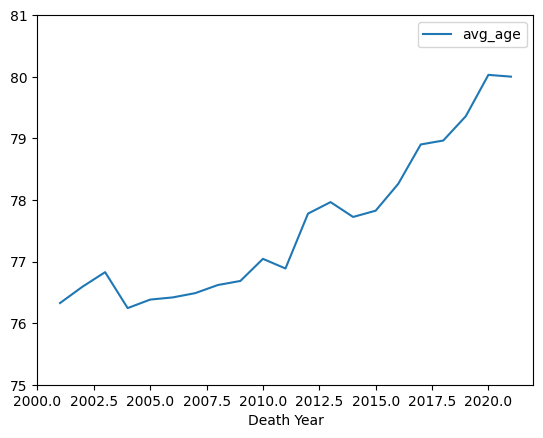

In [35]:
# 'Median' Age by Death-Year for people > 1980
updated_df.createOrReplaceTempView("demographics")

sql_query = """SELECT `Death Year`, mean(`Age of death`) as avg_age
                FROM demographics
                WHERE `Death Year` > 2000
                GROUP BY `Death Year`
                ORDER BY `Death Year`
            """
death_year_med_df = spark.sql(sql_query).toPandas()
death_year_med_df.set_index('Death Year', inplace=True)
death_year_med_df.plot(kind='line').set_yticks(range(75,82))

In [16]:
# 'Average' Age by Country (Top 30 based on famous people)
updated_df.createOrReplaceTempView("demographics")

sql_query = """SELECT Country as C, mean(`Age of death`) as avg_age
                FROM demographics
                GROUP BY Country
            """
country_mean_df = spark.sql(sql_query)
country_df = updated_df.groupBy('Country').agg(count('Country').alias('Country_cnt')).sort(col('Country_cnt').desc()).limit(30)
country_age_death_df = country_df.join(country_mean_df, country_df['Country'] == country_mean_df['C'],"inner")
country_age_death_df.show()

fig = px.bar(country_age_death_df.toPandas(), x = "Country", y = "avg_age")
fig

+--------------------+-----------+--------------------+-----------------+
|             Country|Country_cnt|                   C|          avg_age|
+--------------------+-----------+--------------------+-----------------+
|  Kingdom of England|       4239|  Kingdom of England|58.85845718329795|
|              Sweden|      18606|              Sweden| 72.3538105987316|
|Kingdom of the Ne...|      13470|Kingdom of the Ne...|71.74409799554566|
|             Germany|      78701|             Germany|70.29291876850358|
|              France|      64278|              France|70.25063007560907|
|           Argentina|       5921|           Argentina| 69.0013511231211|
|             Belgium|       9816|             Belgium|71.48645069274653|
|    Kingdom of Italy|       8688|    Kingdom of Italy|63.27232965009208|
|United Kingdom; U...|      28269|United Kingdom; U...| 75.3907460469065|
|             Finland|       8366|             Finland|70.52330863016974|
|        Soviet Union|       4513|    

In [17]:
# Famous People with Age > 100
age_df = updated_df.where(updated_df['Age of death'] > 100)
age_df.show()

+-------+----------------+--------------------+------+-------+----------+----------+----------+---------------+------------+
|     Id|            Name|   Short description|Gender|Country|Occupation|Birth year|Death year|Manner of death|Age of death|
+-------+----------------+--------------------+------+-------+----------+----------+----------+---------------+------------+
|Q182260|  Jeanne Calment|French supercente...|Female| France|     Other|      1875|      1997| natural causes|         122|
|Q435743|Shigechiyo Izumi|Japanese supercen...|  Male|  Japan|     Other|      1865|      1986| natural causes|         121|
+-------+----------------+--------------------+------+-------+----------+----------+----------+---------------+------------+



In [18]:
# Unique ways of death
least_death_10 = updated_df.groupBy('Manner of death').count().orderBy(asc('count')).limit(25)

death_df = updated_df.join(least_death_10, updated_df['Manner of death'] == least_death_10['Manner of death'], "leftsemi")
death_df.show()

+-------+--------------------+--------------------+------+--------------------+------------------+----------+----------+--------------------+------------+
|     Id|                Name|   Short description|Gender|             Country|        Occupation|Birth year|Death year|     Manner of death|Age of death|
+-------+--------------------+--------------------+------+--------------------+------------------+----------+----------+--------------------+------------+
| Q34618|     Gustave Courbet|French painter (1...|  Male|              France|            Artist|      1819|      1877|            epilepsy|          58|
| Q44600|       Kaspar Hauser|A man with a myst...|  Male|Germany; Kingdom ...|            Artist|      1812|      1833|suicide; homicide...|          21|
| Q45765|         Jack London|American author, ...|  Male|              Mexico|            Artist|      1876|      1916|suicide; homicide...|          40|
| Q47878|         Sid Vicious|English bassist a...|  Male|      United

#### In the above results, we can observe some 'interesting' ways, people have passed away like 'patricide' or 'maternal death' or 'cyclohexylamine' which is not common.